In [1]:
import numpy as np
import random
import math
import copy
import pandas as pd
import time
import matplotlib.pyplot as plt


In [2]:
# === Load dataset ===

# Load only the CUSTOMER section of the text file
data = pd.read_fwf("rc104.txt", skiprows=8, header=None)
data.columns = ["CUST_NO", "XCOORD", "YCOORD", "DEMAND", "READY_TIME", "DUE_DATE", "SERVICE_TIME"]


# Load data from previous period
data_pre = pd.read_fwf("rc103.txt", skiprows=8, header=None)
data_pre.columns = ["CUST_NO", "XCOORD", "YCOORD", "DEMAND", "READY_TIME", "DUE_DATE", "SERVICE_TIME"]

# === Sets ===
V = list(range(25))  # 25 vehicles
C = list(range(1, len(data)))  # Customers (1 to n), excluding depot (0)
N = list(range(len(data)))  # All nodes including depot


In [3]:
# === Parameters ===
dc = data['DEMAND'].tolist()
dc[0] = 0  # Depot demand = 0
dc_pre = data_pre['DEMAND'].tolist()
dc_pre[0] = 0  # Depot demand = 0
coords = list(zip(data['XCOORD'], data['YCOORD']))
ai = data['READY_TIME'].tolist()
bi = data['DUE_DATE'].tolist()
si = data['SERVICE_TIME'].tolist()

In [4]:
# Problem parameters
cij = 30
delta = 0.17        #https://progresschamber.org/wp-content/uploads/2024/06/Chamber-of-Progress-Efficiency-and-Emissions-Impact-of-Last-Mile-Online-Delivery-in-the-US.pdf
lambda_v = 200
pi = 10
theta = 0.7
mv = 100000
cv = 100
hv = 15
ev = 0.1
cf = 0.5                                                                                        
fv = 0.1
M = 1000000
w1, w2, w3 = 1, 1, 1  # weight for objectives
alpha_w, beta_w, gamma_w = 1, 1, 1  # penalty weights

dc_rev = [round(d * delta) for d in dc_pre]  # Integer reverse demand!!!!

In [5]:
# === Distance matrix ===
t = np.zeros((len(N), len(N)))
for i in N:
    for j in N:
        t[i][j] = math.hypot(coords[i][0] - coords[j][0], coords[i][1] - coords[j][1])

In [6]:
# === 1. Nearest Neighbor Heuristic ===
def nearest_neighbor_initial_solution():
    unvisited = set(C)
    routes = [[] for _ in V]
    v = 0

    while unvisited:
        if v >= len(V):
            raise RuntimeError("Insufficient vehicles.")
        route = [0]
        load = 0
        curr = 0
        while True:
            nearest = None
            nearest_dist = float('inf')
            for cust in unvisited:
                if dc[cust] + load <= lambda_v and t[curr][cust] < nearest_dist:
                    nearest = cust
                    nearest_dist = t[curr][cust]
            if nearest is None:
                break
            route.append(nearest)
            load += dc[nearest]
            curr = nearest
            unvisited.remove(nearest)
        route.append(0)
        routes[v] = route
        v += 1
    return routes

In [ ]:
initial_routes = nearest_neighbor_initial_solution()

import json
with open("routes_nns.json", "w") as f:
    json.dump(initial_routes, f)

# Preview output
for v, route in enumerate(initial_routes):
    if route:
        print(f"Vehicle {v}: {route}")


Vehicle 0: [0, 90, 65, 66, 83, 64, 56, 95, 92, 91, 80, 94, 93, 71, 96, 0]
Vehicle 1: [0, 69, 98, 53, 88, 55, 100, 70, 68, 61, 81, 54, 72, 41, 39, 62, 0]
Vehicle 2: [0, 82, 99, 52, 57, 86, 74, 87, 59, 97, 75, 58, 77, 85, 0]
Vehicle 3: [0, 67, 50, 34, 31, 29, 27, 26, 28, 30, 32, 33, 63, 73, 0]
Vehicle 4: [0, 60, 78, 12, 14, 47, 17, 16, 15, 13, 9, 24, 20, 0]
Vehicle 5: [0, 84, 51, 76, 89, 18, 48, 21, 23, 25, 49, 0]
Vehicle 6: [0, 2, 6, 7, 8, 46, 4, 45, 5, 3, 1, 44, 0]
Vehicle 7: [0, 10, 11, 79, 42, 43, 40, 36, 0]
Vehicle 8: [0, 22, 19, 38, 37, 35, 0]


In [8]:
# === 2. Cost Function: F(X) + penalty(X) ===
def evaluate_with_penalty(routes):
    Feco = Fenv = Fsoc = Fsat = 0
    penalty = 0
    Qd_total = {i: dc[i] for i in C}
    Qr_total = {i: dc_rev[i] for i in C}

    for route in routes:
        if len(route) < 2:
            continue

        time = 0
        load = 0
        remaining_capacity = lambda_v
        prev = route[0]

        for i in range(len(route) - 1):
            curr, nxt = route[i], route[i + 1]
            dist = t[curr][nxt]
            time += dist

            # Soft time window 
            if curr != 0:
                if time < ai[curr]:
                    time = ai[curr]
                if time > bi[curr]:
                    penalty += beta_w * (time - bi[curr])
                    
                time += si[curr]
                
                # === Forward delivery ===
                demand = Qd_total[curr]
                served_fwd = min(remaining_capacity, demand)
                Qd_total[curr] -= served_fwd
                remaining_capacity -= served_fwd
                
                # === Reverse pickup ===
                reverse = Qr_total[curr]
                served_rev = min(remaining_capacity, reverse)
                Qr_total[curr] -= served_rev
                remaining_capacity -= served_rev

            prev = curr

        # Penalty for exceeding route time
        if time > mv:
            penalty += gamma_w * (time - mv)

        # Cost function
        route_time = time
        route_feco = cv + hv * route_time + \
            sum(t[route[i]][route[i + 1]] * (cf * fv + cij) for i in range(len(route) - 1))
        route_fenv = sum(t[route[i]][route[i + 1]] * ev for i in range(len(route) - 1))
        route_fsoc = route_time

        Feco += route_feco
        Fenv += route_fenv
        Fsoc += route_fsoc

    Feco += pi * (sum(Qd_total[i] for i in C) + (1 - theta) * sum(Qr_total[i] for i in C))
    Fenv += route_fenv
    Fsoc += route_fsoc
    Fsat += sum(theta * Qd_total[i] + (1 - theta) * Qr_total[i] for i in C)
    total_cost = Feco + Fenv + Fsoc + Fsat + penalty
    return total_cost

In [9]:
# === 3. LNS Destruction ===
def random_destroy(routes, fraction=0.5):
    all_customers = [(v, c) for v in range(len(routes)) for c in routes[v] if c != 0]
    num_remove = int(len(all_customers) * fraction)
    to_remove = random.sample(all_customers, num_remove)
    removed = []
    for v, c in to_remove:
        if c in routes[v]:
            routes[v].remove(c)
            removed.append(c)
    return removed, routes


In [10]:
# === 4. Greedy Repair ===
def greedy_repair(routes, removed):
    for cust in removed:
        best_cost = float('inf')
        best_pos = None
        for v in range(len(routes)):
            for i in range(1, max(1, len(routes[v]) - 1)):
                temp_routes = [list(r) for r in routes]
                temp_routes[v].insert(i, cust)
                cost = evaluate_with_penalty(temp_routes)
                if cost < best_cost:
                    best_cost = cost
                    best_pos = (v, i)
        if best_pos:
            v, i = best_pos
            routes[v].insert(i, cust)
    for v in range(len(routes)):
        r = [c for c in routes[v] if c != 0]
        routes[v] = [0] + r + [0] if r else []
    return routes

In [11]:
# === 5. LNS + SA Main Loop ===
def lns_sa(initial_routes, iterations=500, temp=200, cooling=0.98):
    current = copy.deepcopy(initial_routes)
    best = copy.deepcopy(current)
    best_cost = evaluate_with_penalty(current)
    for it in range(iterations):
        removed, partial = random_destroy(copy.deepcopy(current))
        repaired = greedy_repair(partial, removed)
        new_cost = evaluate_with_penalty(repaired)
        delta = new_cost - best_cost
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current = copy.deepcopy(repaired)
            if new_cost < best_cost:
                best = copy.deepcopy(repaired)
                best_cost = new_cost
        temp *= cooling
        if it % 100 == 0:
            print(f"Iter {it}: Best = {best_cost:.2f}")
    return best, best_cost

In [12]:
initial_cost = evaluate_with_penalty(initial_routes)
print("\nInitial Solution (NNS):")
for v, r in enumerate(initial_routes):
    if r: print(f"Vehicle {v}: {r}")
print(f"Initial Cost: {initial_cost:.2f}\n")

lns_routes, lns_cost = lns_sa(initial_routes)
print("\nFinal Solution (LNS + SA):")
for v, r in enumerate(lns_routes):
    if r: print(f"Vehicle {v}: {r}")
print(f"Final Cost: {lns_cost:.2f}")


Initial Solution (NNS):
Vehicle 0: [0, 90, 65, 66, 83, 64, 56, 95, 92, 91, 80, 94, 93, 71, 96, 0]
Vehicle 1: [0, 69, 98, 53, 88, 55, 100, 70, 68, 61, 81, 54, 72, 41, 39, 62, 0]
Vehicle 2: [0, 82, 99, 52, 57, 86, 74, 87, 59, 97, 75, 58, 77, 85, 0]
Vehicle 3: [0, 67, 50, 34, 31, 29, 27, 26, 28, 30, 32, 33, 63, 73, 0]
Vehicle 4: [0, 60, 78, 12, 14, 47, 17, 16, 15, 13, 9, 24, 20, 0]
Vehicle 5: [0, 84, 51, 76, 89, 18, 48, 21, 23, 25, 49, 0]
Vehicle 6: [0, 2, 6, 7, 8, 46, 4, 45, 5, 3, 1, 44, 0]
Vehicle 7: [0, 10, 11, 79, 42, 43, 40, 36, 0]
Vehicle 8: [0, 22, 19, 38, 37, 35, 0]
Initial Cost: 91874.62

Iter 0: Best = 84990.90
Iter 100: Best = 69227.49
Iter 200: Best = 68637.70
Iter 300: Best = 68528.54
Iter 400: Best = 68528.54

Final Solution (LNS + SA):
Vehicle 1: [0, 69, 98, 53, 78, 73, 79, 7, 6, 2, 100, 55, 0]
Vehicle 2: [0, 90, 82, 52, 99, 86, 87, 59, 97, 75, 58, 77, 74, 0]
Vehicle 3: [0, 80, 91, 92, 94, 67, 62, 50, 34, 31, 29, 27, 26, 28, 30, 33, 32, 0]
Vehicle 4: [0, 88, 60, 12, 14, 47

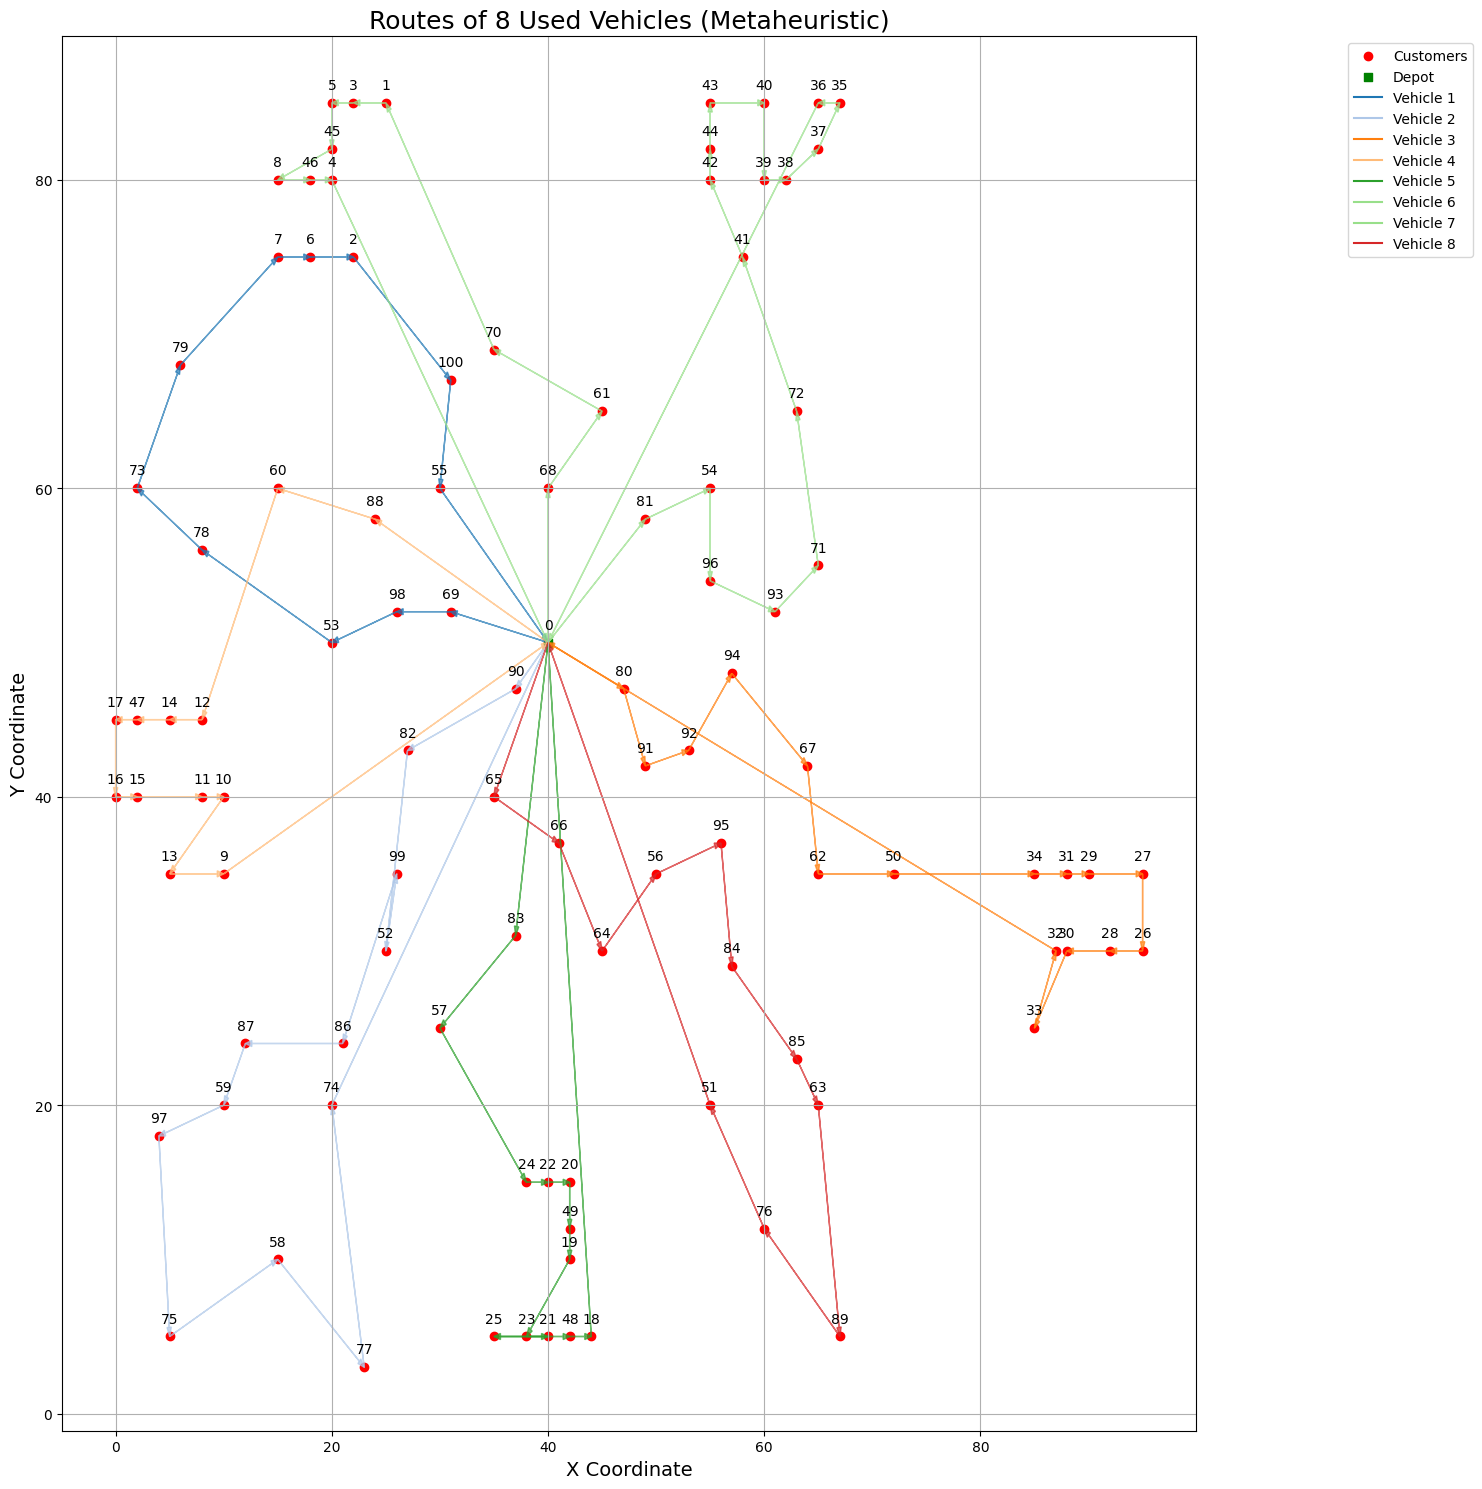

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_metaheuristic_routes(routes, coords, V):
    # Extract X and Y coordinates
    xc = [c[0] for c in coords]
    yc = [c[1] for c in coords]

    plt.figure(figsize=(15, 15))
    plt.scatter(xc, yc, c='red', label='Customers')
    plt.scatter(xc[0], yc[0], c='green', marker='s', label='Depot')

    for i, (x, y_) in enumerate(zip(xc, yc)):
        plt.annotate(str(i), (x, y_), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10)

    cmap = plt.get_cmap('tab20', len(V))
    used_vehicle_count = 0

    for v, route in enumerate(routes):
        if not route or len(route) < 2:
            continue
        used_vehicle_count += 1
        color = cmap(v % 20)

        for i in range(len(route) - 1):
            a, b = route[i], route[i + 1]
            plt.arrow(xc[a], yc[a], xc[b] - xc[a], yc[b] - yc[a],
                      color=color, head_width=0.4, length_includes_head=True, alpha=0.7)

        plt.plot([], [], color=color, label=f'Vehicle {v}')

    plt.xlabel('X Coordinate', fontsize=14)
    plt.ylabel('Y Coordinate', fontsize=14)
    plt.title(f'Routes of {used_vehicle_count} Used Vehicles (Metaheuristic)', fontsize=18)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1), fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_metaheuristic_routes(lns_routes, coords, V)


In [ ]:
def print_metaheuristic_output(routes):
    print("=== Metaheuristic Route Summary ===")
    total_cost = evaluate_with_penalty(routes)

    for v, route in enumerate(routes):
        if not route or len(route) < 3:  # must include at least one customer + depot
            continue

        print(f"Vehicle {v} Route: {route}")
        print(f"{'Node':<8}{'Service Time':<18}{'Cum. Demand':<15}{'Fwd':<6}{'Rev':<6}")
        print("-" * 55)

        time = 0
        cumulative_demand = 0
        load = 0

        for idx in range(1, len(route) - 1):  # skip depot at start and end
            i = route[idx]
            prev = route[idx - 1]
            dist = t[prev][i]

            time += dist
            if time < ai[i]:
                time = ai[i]
            elif time > bi[i]:
                time += (time - bi[i]) * beta_w  

            time += si[i]
            cumulative_demand += dc[i]
            load += dc[i] + dc_rev[i]

            print(f"{i:<8}{time:<18.2f}{cumulative_demand:<15.2f}{dc[i]:<6.0f}{dc_rev[i]:<6.0f}")
        print()

# === Call the report function ===
print_metaheuristic_output(lns_routes)


=== Metaheuristic Route Summary ===
Vehicle 1 Route: [0, 69, 98, 53, 78, 73, 79, 7, 6, 2, 100, 55, 0]
Node    Service Time      Cum. Demand    Fwd   Rev   
-------------------------------------------------------
69      51.00             27.00          27    5     
98      66.00             36.00          9     2     
53      101.00            41.00          5     1     
78      124.42            68.00          27    5     
73      141.63            73.00          5     1     
79      192.14            103.00         30    5     
7       223.09            123.00         20    3     
6       266.18            143.00         20    3     
2       351.36            173.00         30    5     
100     526.81            176.00         3     1     
55      907.76            192.00         16    3     

Vehicle 2 Route: [0, 90, 82, 52, 99, 86, 87, 59, 97, 75, 58, 77, 74, 0]
Node    Service Time      Cum. Demand    Fwd   Rev   
-------------------------------------------------------
90      14.

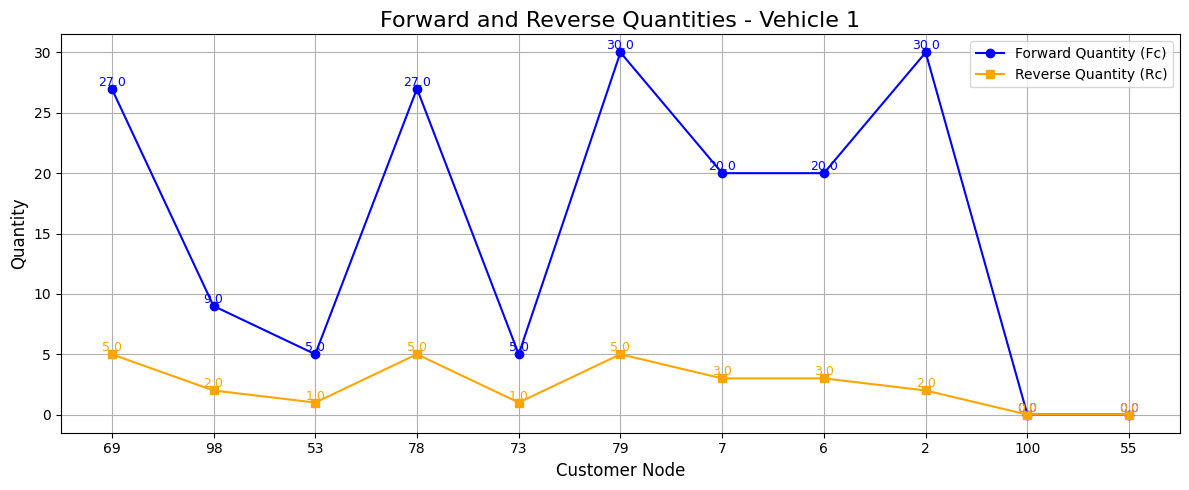

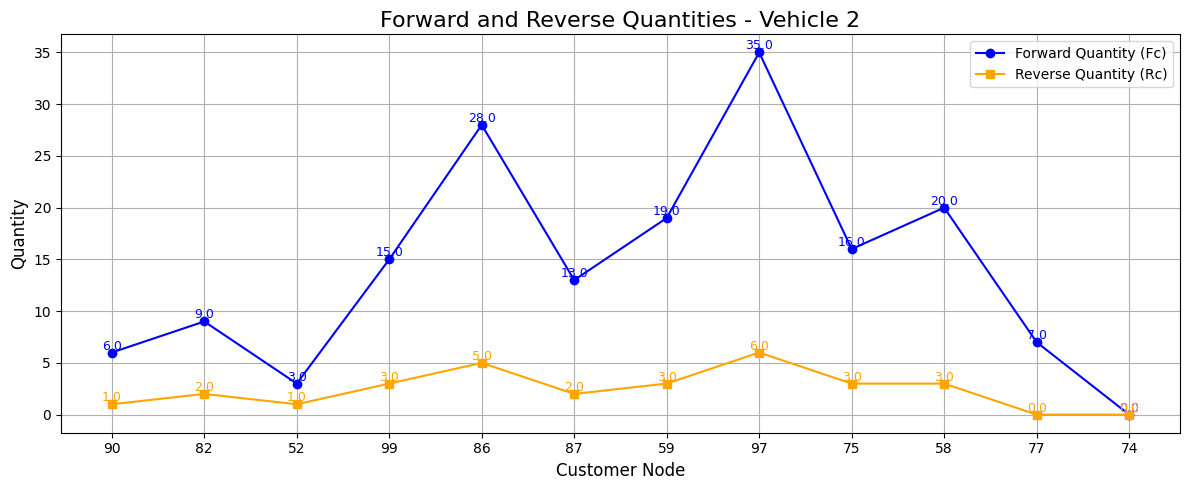

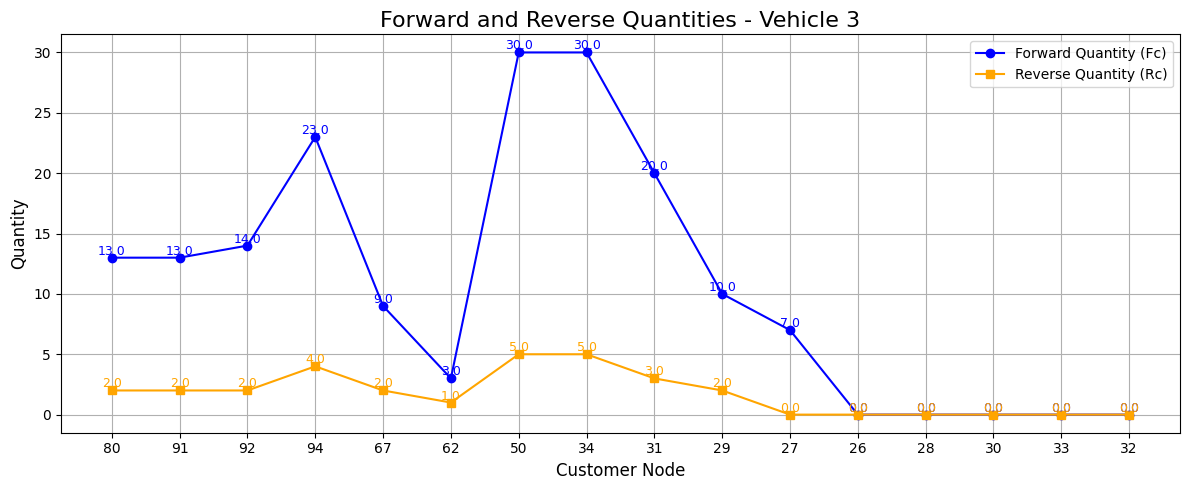

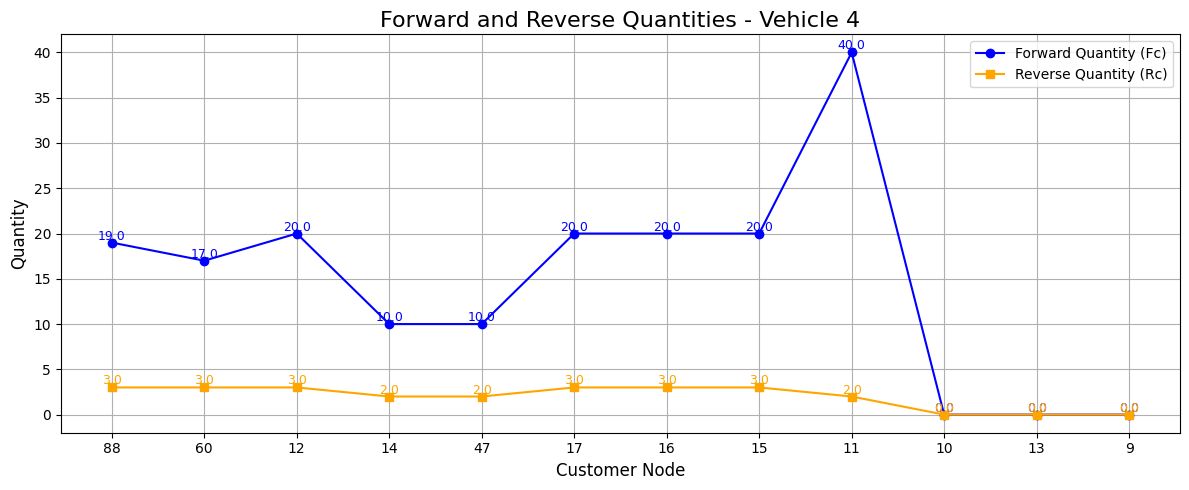

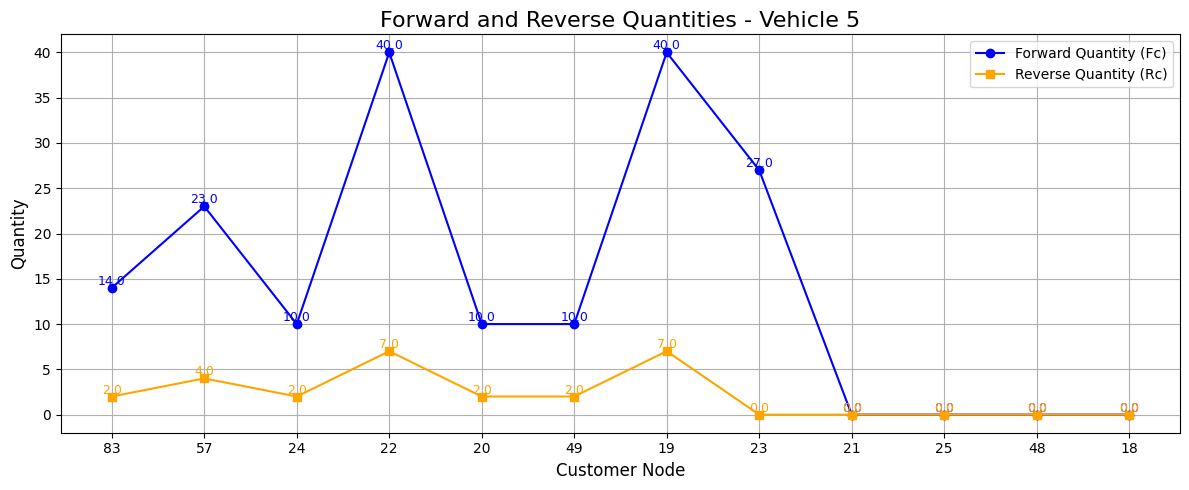

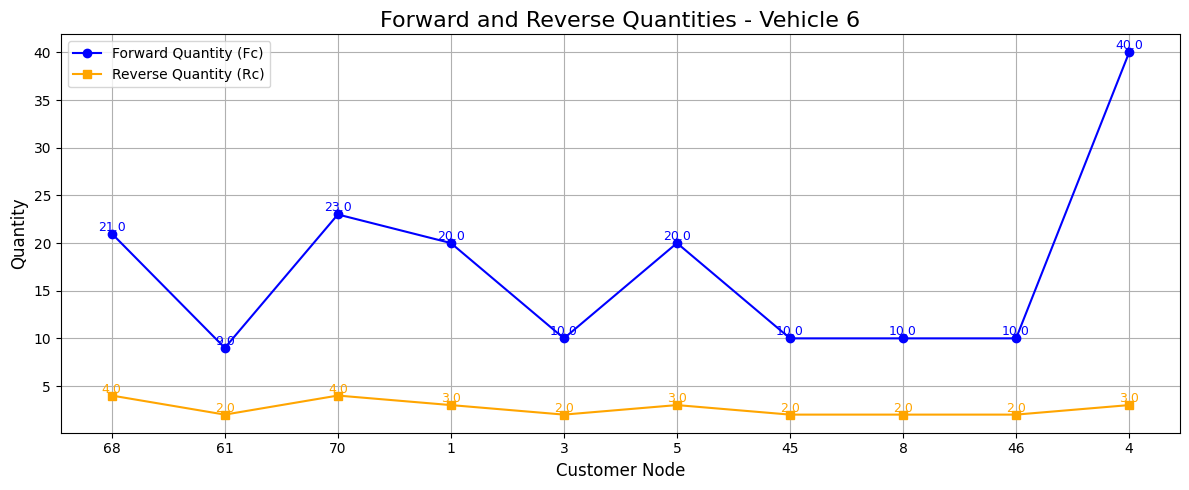

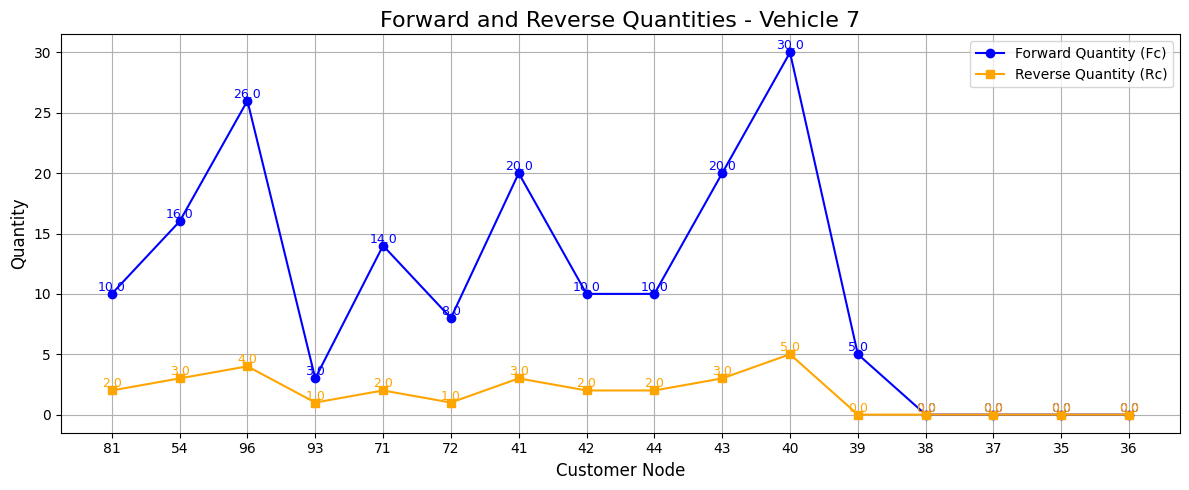

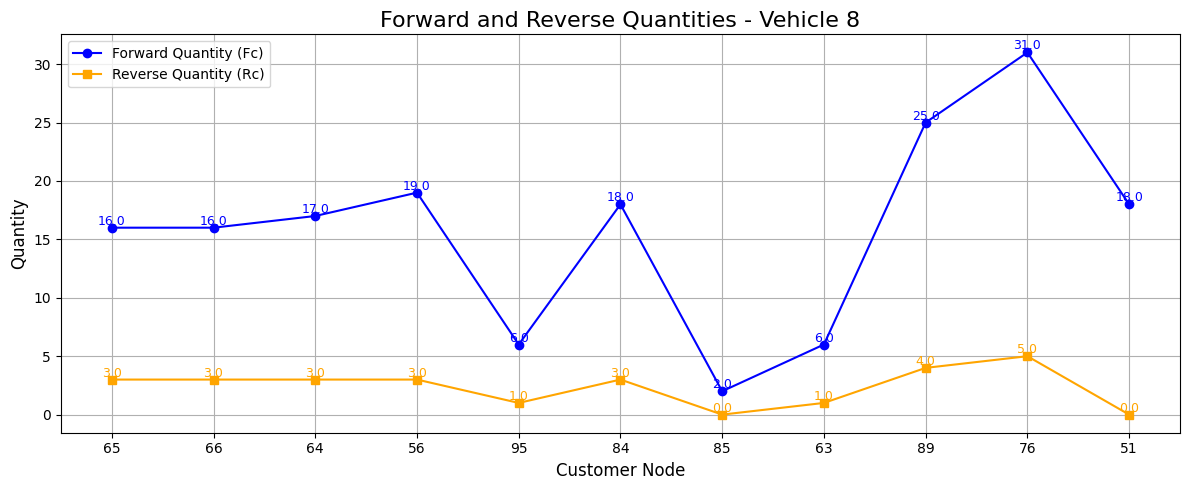

In [15]:
import matplotlib.pyplot as plt

def plot_metaheuristic_quantities(routes):
    for v, route in enumerate(routes):
        if len(route) < 2:
            continue  # skip empty or depot-only routes

        remaining_capacity = lambda_v
        forward_q = []
        reverse_q = []
        customer_seq = []

        Qd_local = {i: dc[i] for i in C}
        Qr_local = {i: dc_rev[i] for i in C}

        for node in route:
            if node == 0:
                continue  # skip depot

            # Forward delivery
            demand = Qd_local[node]
            served_fwd = min(remaining_capacity, demand)
            Qd_local[node] -= served_fwd
            remaining_capacity -= served_fwd

            # Reverse pickup
            reverse = Qr_local[node]
            served_rev = min(remaining_capacity, reverse)
            Qr_local[node] -= served_rev
            remaining_capacity -= served_rev

            forward_q.append(served_fwd)
            reverse_q.append(served_rev)
            customer_seq.append(str(node))

        if customer_seq:
            plt.figure(figsize=(12, 5))
            plt.plot(customer_seq, forward_q, marker='o', label='Forward Quantity (Fc)', color='blue')
            plt.plot(customer_seq, reverse_q, marker='s', label='Reverse Quantity (Rc)', color='orange')

            for idx, val in enumerate(forward_q):
                plt.text(customer_seq[idx], val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, color='blue')
            for idx, val in enumerate(reverse_q):
                plt.text(customer_seq[idx], val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, color='orange')

            plt.title(f'Forward and Reverse Quantities - Vehicle {v}', fontsize=16)
            plt.xlabel('Customer Node', fontsize=12)
            plt.ylabel('Quantity', fontsize=12)
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

# === Call the plotting function with metaheuristic output ===
plot_metaheuristic_quantities(lns_routes)


In [ ]:
# === Update dataset after metaheuristic run ===

def compute_served_unsatisfied(routes):
    served_fwd = [0] * len(N)
    served_rev = [0] * len(N)
    unsat_fwd = dc.copy()
    unsat_rev = dc_rev.copy()

    for route in routes:
        if len(route) < 2:
            continue
        for cust in route:
            if cust == 0:
                continue
            # Forward service
            served_fwd[cust] += dc[cust]
            unsat_fwd[cust] = max(0, unsat_fwd[cust] - dc[cust])
            # Reverse service
            served_rev[cust] += dc_rev[cust]
            unsat_rev[cust] = max(0, unsat_rev[cust] - dc_rev[cust])
    
    return served_fwd, served_rev, unsat_fwd, unsat_rev

served_fwd, served_rev, unsat_fwd, unsat_rev = compute_served_unsatisfied(lns_routes)

# Prepare updated dataset
data_updated = data.copy()
data_updated["REVERSE_DEMAND"] = dc_rev
data_updated["SATISFIED_FWD"] = served_fwd
data_updated["SATISFIED_REV"] = served_rev
data_updated["UNSATISFIED_FWD"] = unsat_fwd
data_updated["UNSATISFIED_REV"] = unsat_rev

# Save and preview
data_updated.to_csv("RC104_updated_from_metaheuristic.txt", sep='\t', index=False)
print("\n=== Updated Dataset (Metaheuristic) ===")
print(data_updated.to_string(index=False))



=== Updated Dataset (Metaheuristic) ===
 CUST_NO  XCOORD  YCOORD  DEMAND  READY_TIME  DUE_DATE  SERVICE_TIME  REVERSE_DEMAND  SATISFIED_FWD  SATISFIED_REV  UNSATISFIED_FWD  UNSATISFIED_REV
       0      40      50       0           0       240             0               0              0              0                0                0
       1      25      85      20           0       191            10               3             20              3                0                0
       2      22      75      30           0       199            10               5             30              5                0                0
       3      22      85      10           0       190            10               2             10              2                0                0
       4      20      80      40         141       171            10               7             40              7                0                0
       5      20      85      20           0       189           